<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d4_updates/tutorials/W2D4_GenerativeModels/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Image, Conditional Diffusion and Beyond

**Week 2, Day 4: Name of the day**

**By Neuromatch Academy**

__Content creators:__ Binxu Wang

__Content reviewers:__ Name Surname, Name Surname

__Content editors:__ Name Surname, Name Surname

__Production editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
#Tutorial Objectives

*   Understand the idea behind Diffusion generative models: score and reversal of diffusion process. 
*   Learn the score function by denoising data. 
*   Hands on experience of learning the score to generate certain distribution.  



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "j89qg"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/j89qg/


---
# Setup

In [2]:
# @title Install dependencies

# @markdown **WARNING**: There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.

!pip install pillow --quiet  # always use quiet
!pip install diffusers transformers tokenizers --quiet
!pip install accelerate --quiet
!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "public_testbed",
            "user_key": "3zg0t05r",
        },
    ).render()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 3.9 MB/s eta 0:00:00


In [3]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
from torchvision.utils import make_grid

In [4]:
# @title Figure settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Plotting functions
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


---
# Section 1: Learning Score Model for Images

We just learned the basic principles of diffusion models, with the takeaway that the score function allows us to turn pure noise into some interesting data distribution. Further, we will approximate the score function with a neural network via denoising score matching. But when working with images, we need our neural network to 'play nice' with them and to reflect the inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a **[U-Net](https://en.wikipedia.org/wiki/U-Net)**, is a CNN-like architecture with:

* downscaling/upscaling operations, that help the network process features of images at different spatial scales. 
* skip connection, as information highway. 

Since the score function we're trying to learn is a function of time, we also need to come up with a way to make sure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

In [9]:
# @title Video 1: Network architecture
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')  
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Wih8AGPoZqo'),] # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [10]:
# @title Submit your feedback
content_review("W2D4_Network_Architecture")

---
# Section 2: Inductive Biases for Learning the Score

## Coding Exercise 1: Train Diffusion for MNIST

Finally let's train an actual image diffusion model for MNIST dataset. 

In [11]:
def marginal_prob_std(t, sigma, device='cpu'):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    std : The standard deviation.
  """
  t = t.to(device)
  #################################################
  ## TODO for students: Implement the standard deviation
  raise NotImplementedError("Student exercise: Implement the standard deviation")
  #################################################
  std = ...
  return std


def diffusion_coeff(t, sigma, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    diff_coeff : The vector of diffusion coefficients.
  """
  #################################################
  ## TODO for students: Implement the diffusion coefficients
  raise NotImplementedError("Student exercise: Implement the diffusion coefficients")
  #################################################
  diff_coeff = ...
  return diff_coeff

In [12]:
# to_remove solution
def marginal_prob_std(t, sigma, device='cpu'):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    std : The standard deviation.
  """
  t = t.to(device)
  std = torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))
  return std


def diffusion_coeff(t, sigma, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    diff_coeff : The vector of diffusion coefficients.
  """
  diff_coeff = sigma**t
  return diff_coeff.to(device)

In [13]:
# @title Time embedding and modulation

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    # this broadcast the 2d tensor to 4d, add the same value across space. 
    return self.dense(x)[..., None, None] 

In [14]:
# @title Defining a time-dependent score-based model 

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.t_mod1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.t_mod2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.t_mod3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.t_mod4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])   
     

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.t_mod5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.t_mod6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.t_mod7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    # Encoding path, downsampling 
    ## Incorporate information from t
    h1 = self.conv1(x)  + self.t_mod1(embed)   
    ## Group normalization  and  apply activation function
    h1 = self.act(self.gnorm1(h1))
    #  2nd conv
    h2 = self.conv2(h1) + self.t_mod2(embed)
    h2 = self.act(self.gnorm2(h2))
    # 3rd conv
    h3 = self.conv3(h2) + self.t_mod3(embed)
    h3 = self.act(self.gnorm3(h3))
    # 4th conv
    h4 = self.conv4(h3) + self.t_mod4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path up sampling 
    h = self.tconv4(h4) + self.t_mod5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1)) + self.t_mod7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Think! 1: UNet Architecture

Looking at the UNet architecture, can you find the module(s) corresponding to the following operations?
1. Downsampling the spatial features?
2. Upsampling the spatial features? 
3. The skip connection from the down branch to up branch, how is it implemented?
5. How is time modulation implemented ? 
5. Why the output is divided by `self.marginal_prob_std(t)` before output? How this might help or harm the score learning?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

In [15]:
# to_remove explanation

"""
Discussion: 

1. Downsampling is implemented as stride in Conv2d
2. Upsampling is implemented as stride in ConvTranspose2d 
3. Skip connection is by concatenation e.g. `self.tconv3(torch.cat([h, h3], dim=1))` 
4. By adding the output of `t_mod` layers `h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)`
5. Inspective the objective we can see the target for s(x,t) is z/\sigma_t. 
so we can divide $\sigma_t$, i.e. the noise scale within the network, thus the neural network only need to model 
data of the same variance ~ 1.

Note this will amplify the noise and signal by a lot when t ~ 0 . 
So it will have large error for low noise conditions. 
The weighting function is kind of counteracting this effect. 
""";

In [16]:
# @title Submit your feedback
content_review("W2D4_UNet_Architecture")

Below is code for an alternate U-Net architecture. Apparently, diffusion models can be successful with somewhat different architectural details. (Note that the differences from the above class are kind of subtle, though.)

* Upper one, **concatenate the tensor from the down block** for skip connection. 

### Defining the loss function

The loss function is mostly defined below. **You need to add one part**: sample random noise with strength `std[:, None, None, None]`, and make sure it has the same shape as $\mathbf{x}$. Then use this to perturb $\mathbf{x}$. (*the shape of `std` need to be broadcast to implement the equations*)

*Hint: `torch.randn_like()` may be useful.*

In [17]:
def loss_fn(model, x, marginal_prob_std, eps=1e-3, device='cpu'):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in eps, 1
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps 
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t).to(device)
  #################################################
  ## TODO for students: Implement the denoising score matching eq. 
  raise NotImplementedError("Student exercise: Implement the denoising score matching eq. ")
  #################################################
  # get normally distributed noise N(0, I)
  z = ...
  # compute the perturbed x = x + z * \sigma_t
  perturbed_x = ...
  # predict score with the model at (perturbed x, t)
  score = ...
  # compute distance between the score and noise \| score * sigma_t + z \|_2^2
  loss = ...
  ##############
  return loss

In [18]:
# to_remove solution
def loss_fn(model, x, marginal_prob_std, eps=1e-3, device='cpu'):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in eps, 1
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps 
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t).to(device)
  # get normally distributed noise N(0, I)
  z = torch.randn_like(x).to(device)
  # compute the perturbed x = x + z * \sigma_t
  perturbed_x = x + z * std[:, None, None, None]
  # predict score with the model at (perturbed x, t)
  score = model(perturbed_x, random_t)
  # compute distance between the score and noise \| score * sigma_t + z \|_2^2
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
  ##############
  return loss

Note if the training takes too long, 50 epoch with 1024 batch size also suffice. Average loss around ~30 is able to generate acceptable digits. 

In [19]:
# @title Training the model
sigma = 25.0  # @param {'type':'number'}

marginal_prob_std_fn = lambda t: marginal_prob_std(t, sigma=sigma, device=DEVICE)
diffusion_coeff_fn = lambda t: diffusion_coeff(t, sigma=sigma, device=DEVICE)
score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(DEVICE)

n_epochs = 5  # @param {'type':'integer'}
# size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
# learning rate
lr = 10e-4  # @param {'type':'number'}

set_seed(SEED)
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
g = torch.Generator()
g.manual_seed(SEED)
data_loader = DataLoader(dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g,)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 1 - epoch / n_epochs))
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  pbar = tqdm(data_loader)
  for x, y in pbar:
    x = x.to(DEVICE)
    loss = loss_fn(score_model, x, marginal_prob_std_fn, eps=0.01, device=DEVICE)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  print(f"Average Loss: {(avg_loss / num_items):5f} lr {scheduler.get_last_lr()[0]:.1e}")
  # Print the averaged training loss so far.
  tqdm_epoch.set_description(f'Average Loss: {(avg_loss / num_items):.5f}')
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

Random seed 2021 has been set.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 866.554431 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 230.321842 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 158.463945 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 127.868915 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 114.370217 lr 2.0e-04


In [20]:
# @title Sampler code
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=500, 
              device='cuda', 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size).to(device)
  r = torch.randn(batch_size, *x_shape).to(device)
  init_x = r * marginal_prob_std(t)[:, None, None, None]
  init_x = init_x.to(device)
  time_steps = torch.linspace(1., eps, num_steps).to(device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

  0%|          | 0/250 [00:00<?, ?it/s]

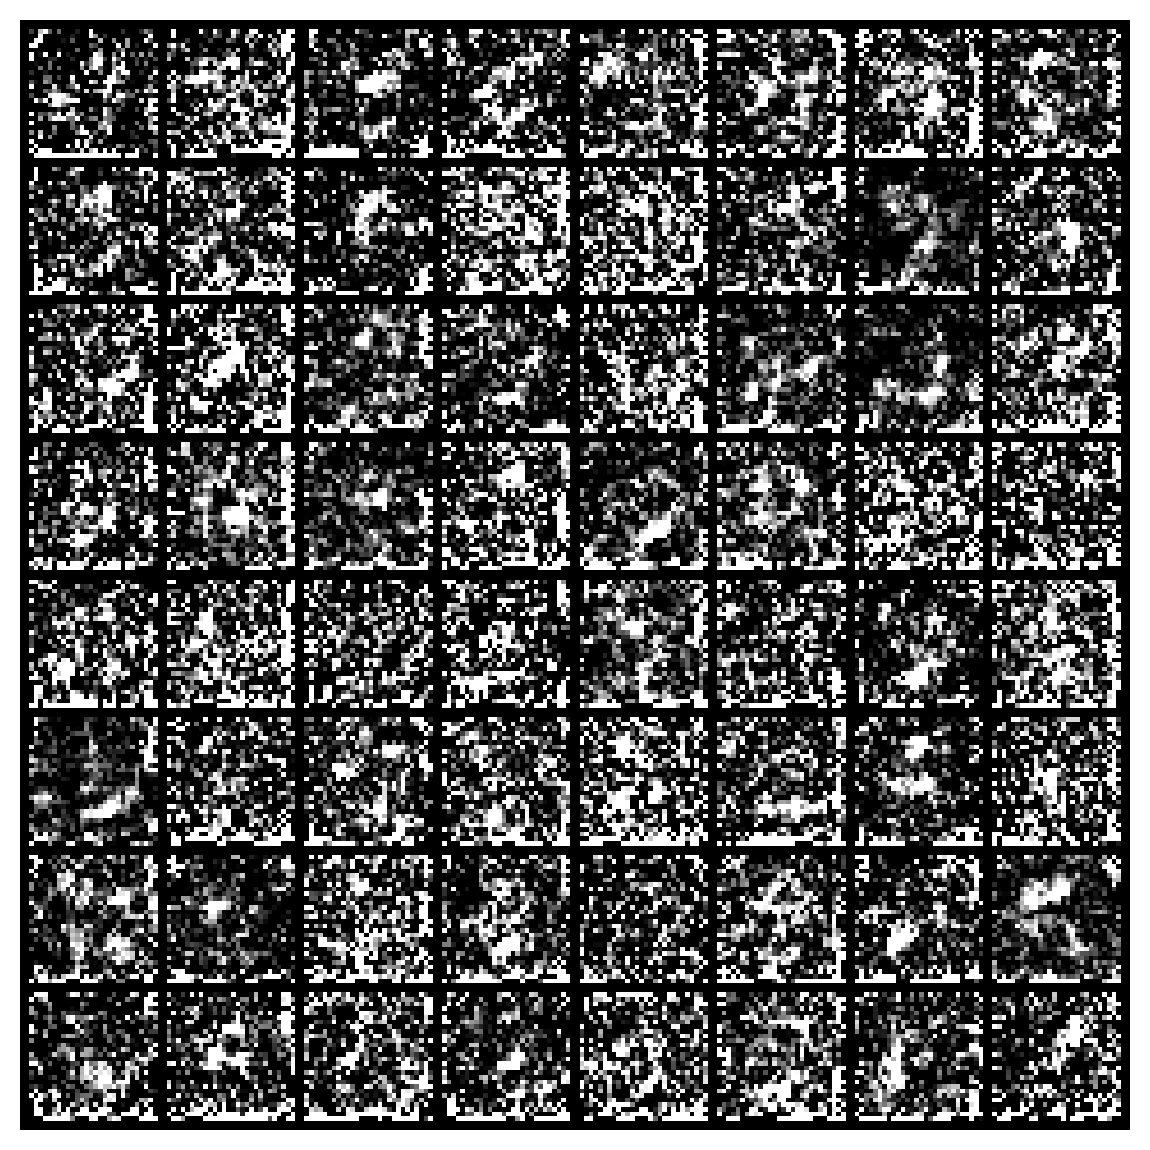

In [21]:
# @title Sampling
def save_samples_uncond(score_model, suffix="", device='cpu'):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64  # @param {'type':'integer'}
  num_steps = 250  # @param {'type':'integer'}
  # sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = Euler_Maruyama_sampler(score_model,
                                   marginal_prob_std_fn,
                                   diffusion_coeff_fn,
                                   sample_batch_size,
                                   num_steps=num_steps,
                                   device=DEVICE,
                                   eps=0.001)

  # Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion{suffix}.png", sample_np, )
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()


marginal_prob_std_fn = lambda t: marginal_prob_std(t, sigma=sigma, device=DEVICE)
uncond_score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
uncond_score_model.load_state_dict(torch.load("ckpt.pth"))
uncond_score_model.to(DEVICE)
save_samples_uncond(uncond_score_model, suffix="", device=DEVICE)

Nice job! you finished the training of the Diffusion model, as you see, the result is not ideal and many factors affects this. To name a few:

* **Better network architecture**: residual connections, attention mechanism, better upsampling mechanism
* **Better objective**: better weighting function $\gamma_t$
* **Better optimization procedure**: using learning rate decay
* **Better sampling algorithm**: Euler integration is known to have larger errors, so it's advicable to using more advanced SDE or ODE solver

In [22]:
# @title Submit your feedback
content_review("W2D4_Sampling")

---
# Section 2: Conditional Diffusion Model

There is another way which can greatly improve the result, which is adding a conditional signal -- for example, tell the score network which digit you want. This makes the score modelling much easier and also add controlability to the user. The popular Stable Diffusion model is one of this kind, which use natural language text as the conditional signal for images. 

In [23]:
# @title Video 2: Conditional Diffusion Model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')  
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Wih8AGPoZqo')]  # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In formulation the conditional diffusion is highly similar to the unconditional diffusion 

In [24]:
# @title Submit your feedback
content_review("W2D4_Conditional_Diffusion_Model")

---
## Interactive Demo 2: Stable Diffusion

In this demo we will play with one of the most powerful open source diffusion models Stable Diffusion 2.1, and try to make connections with what we have learned. 

In [25]:
# @title Video 3: Advanced Techinque - Stable Diffusion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')  
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0ZVXyRpScP8')]  # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [26]:
# @title Submit your feedback
content_review("W2D4_Advanced Techinque - Stable Diffusion")

In [27]:
#@title Download the Stable Diffusion models
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, PNDMScheduler

model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# Use the PNDM scheduler as default
# pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

Now you can let loose your imagination and create artworks from text! 

Example prompts:

```python
prompt = "A lovely cat running on the dessert in Van Gogh style, trending art."
prompt = "A ballerina dancing under the starry night in Monet style, trending art."
```

  0%|          | 0/50 [00:00<?, ?it/s]

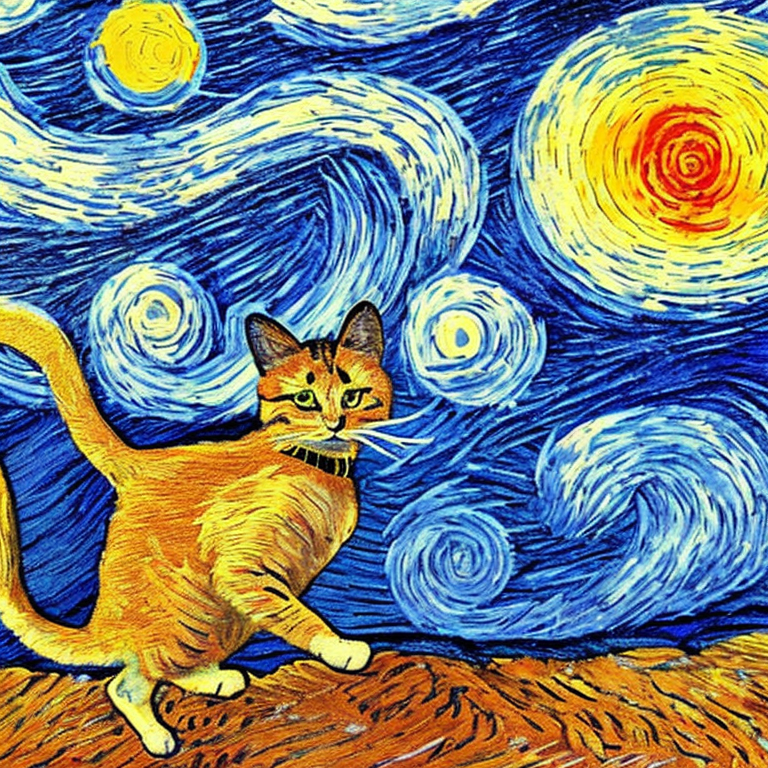

In [28]:
prompt = "A lovely cat running on the dessert in Van Gogh style, trending art." # @param {'type':'string'}
my_seed = 2023  # @param {'type':'integer'}
image = pipe(prompt, num_inference_steps=50,
             generator=torch.Generator("cuda").manual_seed(my_seed)).images[0]
image

In [29]:
# @title Helper function to inspect network
def recursive_print(module, prefix="", depth=0, deepest=3):
  """Simulating print(module) for torch.nn.Modules
      but with depth control. Print to the `deepest` level. `deepest=0` means no print
  """
  if depth == 0:
    print(f"[{type(module).__name__}]")
  if depth >= deepest:
    return
  for name, child in module.named_children():
    if len([*child.named_children()]) == 0:
      print(f"{prefix}({name}): {child}")
    else:
      if isinstance(child, nn.ModuleList):
        print(f"{prefix}({name}): {type(child).__name__} len={len(child)}")
      else:
        print(f"{prefix}({name}): {type(child).__name__}")
    recursive_print(child, prefix=prefix + "  ", depth=depth + 1, deepest=deepest)

## Think! 2 Architecture of Stable Diffusion Model
Can you see the similarity between the UNet in Stable Diffusion and the baby UNet we defined up there? 
You can use the `recursive_print(pipe.unet,deepest=2)` function with different `deepest` to inspect the architecture. 

The text is encoded through the CLIP model, you can also look at its structure below `recursive_print(pipe.text_encoder,deepest=4)` which is a large transformer! 

Take 2 minutes to think and play with code, then discuss as a group (~10 minutes). 

In [30]:
recursive_print(pipe.unet,deepest=2)

[UNet2DConditionModel]
(conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(time_proj): Timesteps()
(time_embedding): TimestepEmbedding
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
(down_blocks): ModuleList len=4
  (0): CrossAttnDownBlock2D
  (1): CrossAttnDownBlock2D
  (2): CrossAttnDownBlock2D
  (3): DownBlock2D
(up_blocks): ModuleList len=4
  (0): UpBlock2D
  (1): CrossAttnUpBlock2D
  (2): CrossAttnUpBlock2D
  (3): CrossAttnUpBlock2D
(mid_block): UNetMidBlock2DCrossAttn
  (attentions): ModuleList len=1
  (resnets): ModuleList len=2
(conv_norm_out): GroupNorm(32, 320, eps=1e-05, affine=True)
(conv_act): SiLU()
(conv_out): Conv2d(320, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [31]:
recursive_print(pipe.text_encoder,deepest=4)

[CLIPTextModel]
(text_model): CLIPTextTransformer
  (embeddings): CLIPTextEmbeddings
    (token_embedding): Embedding(49408, 1024)
    (position_embedding): Embedding(77, 1024)
  (encoder): CLIPEncoder
    (layers): ModuleList len=23
      (0): CLIPEncoderLayer
      (1): CLIPEncoderLayer
      (2): CLIPEncoderLayer
      (3): CLIPEncoderLayer
      (4): CLIPEncoderLayer
      (5): CLIPEncoderLayer
      (6): CLIPEncoderLayer
      (7): CLIPEncoderLayer
      (8): CLIPEncoderLayer
      (9): CLIPEncoderLayer
      (10): CLIPEncoderLayer
      (11): CLIPEncoderLayer
      (12): CLIPEncoderLayer
      (13): CLIPEncoderLayer
      (14): CLIPEncoderLayer
      (15): CLIPEncoderLayer
      (16): CLIPEncoderLayer
      (17): CLIPEncoderLayer
      (18): CLIPEncoderLayer
      (19): CLIPEncoderLayer
      (20): CLIPEncoderLayer
      (21): CLIPEncoderLayer
      (22): CLIPEncoderLayer
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)


In [32]:
# @title Submit your feedback
content_review("W2D4_UNet_vs_babyUNet")

---
# Section 3: Ethical Considerations



In [33]:
# @title Video 4: Ethical Consideration
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')  
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [34]:
# @title Submit your feedback
content_review("W2D4_Ethical_Consideration")

## Think! 3: Copyright of imagery generated from diffusion generated models

If you prompt a pretrained diffusion model with the name of the artist, and obtain a beautiful imagery similar to the style of that artist. Who have copyright of the generated image? The producing company of the diffusion model, the original artist, you the prompter, the random seed and the weights, or the GPU that runs the inference? 

Who do you think deserve the credit and why? 

What if you apply enough post processing steps to the generated images? e.g. finetune the prompt and seed, or edit the image?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).


In [35]:
# @title Submit your feedback
content_review("W2D4_copyright of SD image ")

---
# Summary

Today, we learnt about 

* One major application for diffusion model i.e. to model natural image. 

* The suitable inductive bias for images: UNet architecture and time modulation mechansim. 

* Conditional diffusion models esp. Stable Diffusion. 

* Some ethical considerations around diffusion models, regarding copyright, misinformation and fairness.  

---
# Bonus Coding Exercies: Train Conditional Diffusion for MNIST 

In this part, we'd like to train a MNIST generative model conditioned on the digit. 